In [1]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import scipy as sp
import random as rn
from heapq import nlargest

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)
import community as community_louvain

In [2]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)

In [3]:
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

In [8]:
# remove the essential nodes from G0
ess=pd.read_csv("essential_pro.csv",header=None)
ess_pro=pd.Series.to_list(ess[1])
for i in range(len(ess_pro)):
    ess_pro[i]='4932.'+ess_pro[i]
G0.remove_nodes_from(ess_pro)

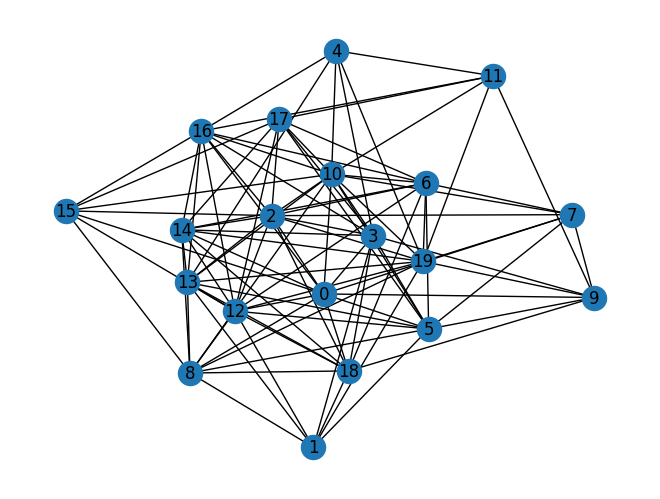

In [149]:
## Test Graph

G1 = nx.fast_gnp_random_graph(20, p= 0.5)
nx.draw(G1, with_labels = True)

l_part = nx_comm.louvain_communities(G1, resolution = 1, seed = 1)


In [152]:
l_part

len(G1.edges())

99

{(1, 3): Text(-0.238954877793714, -0.44782980682015966, '20'),
 (1, 2): Text(-0.2610451222062862, 0.3603599863219379, '14'),
 (2, 3): Text(0.4999999999999998, 0.08746982049822177, '20')}

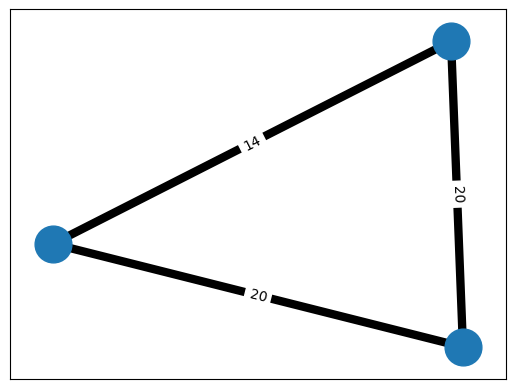

In [151]:
def part_graph(G_1, partition):
    N = len(partition) # Number of communities 
    G = nx.Graph()
    for i in range (1, N+1): 
        G.add_node(i)
    for edge in G_1.edges():
        n1 = edge[0]
        n2 = edge[1]

        for p1 in range(0,N):
            comm1 = partition[p1]
            for p2 in range(0, N):
                comm2 = partition[p2]
                if n1 in comm1 and n2 in comm2:
                    if comm1 == comm2: 
                        continue
                    if G.has_edge(p1+1, p2+1): 
                        G[p1+1][p2+1]["weight"] +=1
                    else:
                        G.add_edge(p1+1, p2+1, weight = 1)
    return G


G2 = part_graph(G1, l_part)
edge_labels = nx.get_edge_attributes(G2, "weight")
pos = nx.spring_layout(G2, seed=7)

nx.draw_networkx_nodes(G2, pos, node_size=700)
nx.draw_networkx_edges(G2, pos, width=6)
nx.draw_networkx_edge_labels(G2, pos, edge_labels)
